In [ ]:
# default_exp g_models.lstm_lm

# LSTM Language Model

> LSTM-based language model

In [ ]:
#hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [ ]:
# export

from mrl.imports import *
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.g_models.generative_base import *

In [ ]:
# export

class LSTM_LM(GenerativeModel):
    def __init__(self, d_vocab, d_embedding, d_hidden, n_layers,
                input_dropout=0., lstm_dropout=0., bos_idx=0, 
                bidir=False, tie_weights=False):
        super().__init__()
        
        self.embedding = nn.Embedding(d_vocab, d_embedding)
        
        self.lstm = LSTM(d_embedding, d_hidden, d_embedding, n_layers,
                                     bidir=bidir, input_dropout=input_dropout,
                                     lstm_dropout=lstm_dropout)
        
        self.head = nn.Linear(d_embedding, d_vocab)
        
        if tie_weights:
            self.embedding.weight = self.head.weight
            
        self.bos_idx = bos_idx

    def _forward(self, x, hiddens=None):
        x = self.embedding(x)
        encoded, hiddens = self.lstm(x, hiddens)
        output = self.head(encoded)
        return output, hiddens, encoded
        
    def forward(self, x, hiddens=None):
        output, hiddens, encoded = self._forward(x, hiddens)
        
        return output
    
    def x_to_latent(self, x):
        return None
    
    def sample(self, bs, sl, z=None, temperature=1., multinomial=True):
        
        current_device = next(self.parameters()).device
        
        start_idx = torch.tensor([self.bos_idx]*bs).long().unsqueeze(-1)
        
        preds = idxs = to_device(start_idx, device=current_device)
        lps = []

        hiddens = None
        
        for i in range(sl):
            x, hiddens, encoded = self._forward(idxs, hiddens)
            x.div_(temperature)
            
            idxs, lp = x_to_preds(x, multinomial=multinomial)
            
            lps.append(lp)            
            preds = torch.cat([preds, idxs], -1)
            
        return preds[:, 1:], torch.cat(lps,-1)
    
    def sample_no_grad(self, bs, sl, z=None, temperature=1., multinomial=True):
        with torch.no_grad():
            return self.sample(bs, sl, temperature=temperature, multinomial=multinomial)
        
    def get_rl_tensors(self, x, y, temperature=1., latent=None):
        output, hiddens, encoded = self._forward(x)
        output.div_(temperature)
        lps = F.log_softmax(output, -1)
        lps_gathered = gather_lps(lps, y)
        return output, lps, lps_gathered, encoded

In [ ]:
lm = LSTM_LM(32, 64, 256, 2)
ints = torch.randint(0, 31, (16, 10))
x = ints[:,:-1]
y = ints[:,1:]
out = lm(x)

o,lp,lpg,e = lm.get_rl_tensors(x,y)

_ = lm.sample(8, 10)

to_device(lm)
x = to_device(x)
y = to_device(y)

o,lp,lpg,e = lm.get_rl_tensors(x,y)

_ = lm.sample(8, 10)

In [ ]:
# export

class Conditional_LSTM_LM(GenerativeModel):
    def __init__(self, encoder, d_vocab, d_embedding, d_hidden, d_latent, n_layers,
                 input_dropout=0., lstm_dropout=0., norm_latent=True,
                 condition_hidden=True, condition_output=False, bos_idx=0, prior=None):
        super().__init__()
        
        self.encoder = encoder
        
        self.decoder = Conditional_LSTM_Block(d_vocab, d_embedding, d_hidden, d_embedding,
                                d_latent, n_layers, input_dropout=input_dropout, 
                                lstm_dropout=lstm_dropout,
                                condition_hidden=condition_hidden, condition_output=condition_output)
        
        self.norm_latent = norm_latent
        self.bos_idx = bos_idx
        
        if prior is None:
            prior = SphericalPrior(torch.zeros((encoder.d_latent)), torch.zeros((encoder.d_latent)), 
                                trainable=False)
            
        self.prior = prior
        
    def forward(self, x, condition, hiddens=None):
        z = self.encoder(condition)
        
        z = self.maybe_norm(z)
            
        x, hiddens, encoded = self.decoder(x, z, hiddens)
        return x
    
    def maybe_norm(self, z):
        if self.norm_latent:
            z = F.normalize(z, p=2, dim=-1)
            
        return z
            
    def x_to_latent(self, x):
        
        x, condition = x
        z = self.encoder(condition)
        z = self.maybe_norm(z)

        return z
    
    def sample(self, bs, sl, z=None, temperature=1., multinomial=True):
        
        current_device = next(self.parameters()).device
        
        if z is None:
            if self.prior is not None:
                z = to_device(self.prior.rsample([bs]), device=current_device)
            else:
                z = to_device(torch.randn((bs, self.encoder.d_latent)), device=current_device)
        else:
            bs = z.shape[0]
            
        z = self.maybe_norm(z)
        
        start_idx = torch.tensor([self.bos_idx]*bs).long().unsqueeze(-1)
        
        preds = idxs = to_device(start_idx, device=current_device)
        
        lps = []

        hiddens = None
        
        for i in range(sl):
            
            x, hiddens, encoded = self.decoder(idxs,z,hiddens)
            x.div_(temperature)
            
            idxs, lp = x_to_preds(x, multinomial=multinomial)
            
            lps.append(lp)            
            preds = torch.cat([preds, idxs], -1)
            
        return preds[:, 1:], torch.cat(lps,-1)
    
    def sample_no_grad(self, bs, sl, z=None, temperature=1., multinomial=True):
        with torch.no_grad():
            return self.sample(bs, sl, z=z, temperature=temperature, multinomial=multinomial)
        
    def get_rl_tensors(self, x, y, temperature=1., latent=None):
        x,c = x
        if latent is None:
            latent = self.encoder(c)
            
        latent = self.maybe_norm(latent)
            
        output, hiddens, encoded = self.decoder(x,latent)
        output.div_(temperature)
        lps = F.log_softmax(output, -1)
        
        if self.prior.trainable:
            prior_lps = self.prior.log_prob(latent)
            prior_lps = prior_lps.mean(-1).unsqueeze(-1).unsqueeze(-1)
            pass_through = torch.zeros(prior_lps.shape).float().to(prior_lps.device)
            pass_through = pass_through + prior_lps - prior_lps.detach() # add to gradient chain
            lps = lps + pass_through
        
        lps_gathered = gather_lps(lps, y)
        return output, lps, lps_gathered, encoded
    
    def set_prior_from_latent(self, z, logvar, trainable=False):
        z = z.detach()
        logvar = logvar.detach()
        self.prior = SphericalPrior(z, logvar, trainable)
        
    def set_prior_from_encoder(self, condition, logvar, trainable=False):
        assert condition.shape[0]==1
        z = self.encoder(condition)
        z = self.maybe_norm(z)
        z = z.squeeze(0)
        self.set_prior_from_latent(z, logvar, trainable)

In [ ]:
encoder = MLP_Encoder(128, [64, 32], 16, [0.1, 0.1])

lm = Conditional_LSTM_LM(encoder, 32, 64, 128, 16, 2)

ints = torch.randint(0, 31, (8, 10))
x = ints[:,:-1]
y = ints[:,1:]

condition = torch.randn((8,128))

prior = SphericalPrior(torch.zeros((encoder.d_latent,)), 
                            torch.zeros((encoder.d_latent,)), True)


_ = lm(x, condition)

o,lp,lpg,e = lm.get_rl_tensors([x,condition],y)

_ = lm.sample(3, 80)

lm.prior = prior

o,lp,lpg,e = lm.get_rl_tensors([x,condition],y)

loss = lpg.mean()

assert lm.prior.loc.grad is None

loss.backward()

assert lm.prior.loc.grad is not None

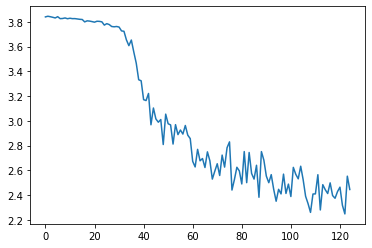

In [ ]:
# slow

# standard lm

from mrl.vocab import *
from mrl.dataloaders import *

df = pd.read_csv('files/smiles.csv')
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = TextDataset(df.smiles.values, vocab)
dl = ds.dataloader(16, num_workers=0)
loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

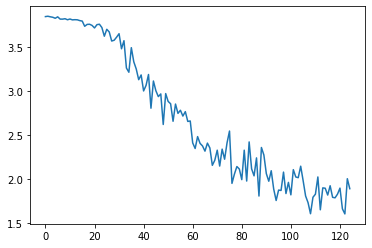

In [ ]:
# slow

# fp conditional lm

from mrl.vocab import *
from mrl.dataloaders import *
from mrl.chem import ECFP6

df = pd.read_csv('files/smiles.csv')
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Vec_To_Text_Dataset(df.smiles.values, vocab, ECFP6)
dl = ds.dataloader(16, num_workers=0)
loss = CrossEntropy()


encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']
norm_latent = True

model = Conditional_LSTM_LM(encoder, 
                               d_vocab, 
                               d_embedding, 
                               d_hidden, 
                               d_latent, 
                               n_layers,
                               input_dropout, 
                               lstm_dropout, 
                               norm_latent,
                               condition_hidden, 
                               condition_output, 
                               bos_idx)

to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(*x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

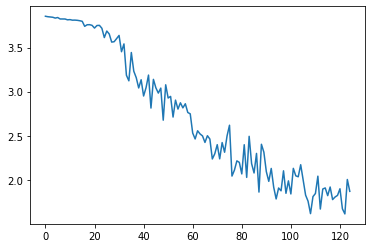

In [ ]:
# slow

# vec to text

from mrl.vocab import *
from mrl.dataloaders import *
from mrl.chem import ECFP6
from rdkit.Chem.Scaffolds import MurckoScaffold
from mrl.chem import to_mol, to_smile


df = pd.read_csv('files/smiles.csv')
source_smiles = [to_smile(MurckoScaffold.GetScaffoldForMol(to_mol(i))) for i in df.smiles.values]
target_smiles = df.smiles.values
smiles = [(source_smiles[i], target_smiles[i]) for i in range(len(source_smiles))]

vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Vec_To_Text_Dataset(smiles, vocab, ECFP6)
dl = ds.dataloader(16, num_workers=0)
loss = CrossEntropy()

encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']
norm_latent = True

model = Conditional_LSTM_LM(encoder, 
                               d_vocab, 
                               d_embedding, 
                               d_hidden, 
                               d_latent, 
                               n_layers,
                               input_dropout, 
                               lstm_dropout, 
                               norm_latent,
                               condition_hidden, 
                               condition_output, 
                               bos_idx)

to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(*x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

In [ ]:
# hide
from nbdev.export import notebook2script; notebook2script()